##Demo test.restoration.test_unsupervised_wiener()

The unit test ```test_unsupervised_wiener``` is now the slowest test in scikit-image. 
Speeding this up requires more than cutting a patch out of the test image and comparing with the same patch in the fiducial output (which consists of 2.0M uncompressed numpy arrays on disk):

```
-rw-r--r--  1   2.0M Jul 11 10:42 camera_unsup.npy
-rw-r--r--  1   2.0M Jul 11 10:42 camera_unsup2.npy
```

I recommend replacing these with the smaller images or reducing the tolerance on the assert close. Please advise. 

http://scikit-image.org/docs/dev/api/skimage.restoration.html#skimage.restoration.unsupervised_wiener

In [1]:
from os.path import abspath, dirname, join as pjoin

import numpy as np
from scipy.signal import convolve2d
from scipy import ndimage as ndi

import skimage
from skimage.data import camera
from skimage import restoration
from skimage.restoration import uft
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test_img = skimage.img_as_float(camera())

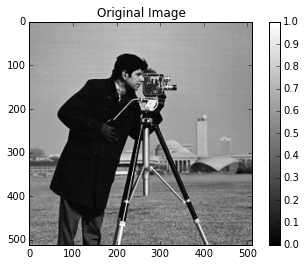

In [3]:
plt.imshow(test_img, cmap='gray')
plt.colorbar()
plt.title('Original Image')
plt.show()

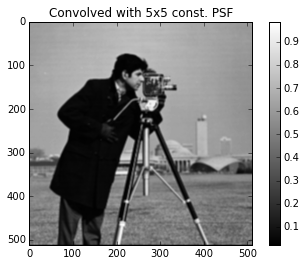

In [4]:
psf = np.ones((5, 5)) / 25
data = convolve2d(test_img, psf, 'same')
plt.imshow(data, cmap='gray')
plt.colorbar()
plt.title('Convolved with 5x5 const. PSF')
plt.show()

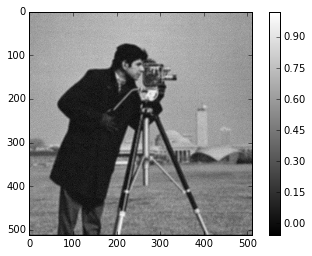

In [5]:
np.random.seed(0)
data += 0.1 * data.std() * np.random.standard_normal(data.shape)
plt.imshow(data, cmap='gray')
plt.colorbar()
plt.show()

In [6]:
deconvolved, _ = restoration.unsupervised_wiener(data, psf)
output_on_disk = np.load('skimage/restoration/tests/camera_unsup.npy')

Output matches the expected result on disk:

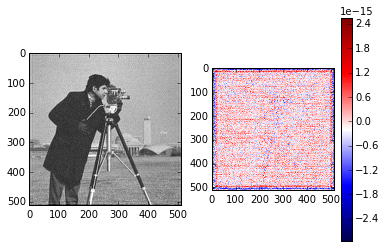

In [7]:
plt.subplot(121)
plt.imshow(deconvolved, cmap='gray')
plt.subplot(122)
plt.imshow(deconvolved - output_on_disk, cmap='seismic')
plt.colorbar()
plt.show()

In [8]:
np.testing.assert_allclose(np.real(deconvolved),
                           output_on_disk,
                           rtol=1e-3)


But the deconvolved image has ringing and correlated noise

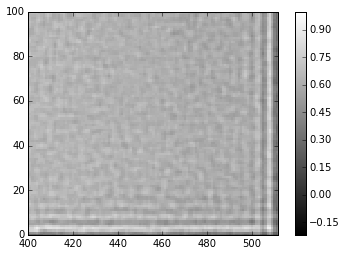

In [9]:
plt.imshow(deconvolved, cmap='gray', interpolation='nearest')
plt.axis([400, 512, 0, 100])
plt.colorbar()
plt.show()

#Now, let us try to run on the middle of the image:

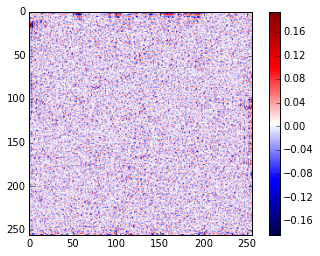

In [11]:
test_slice = np.index_exp[128:384, 128:384]
pad_pix = 25
deconvolved_new, _ = restoration.unsupervised_wiener(skimage.util.pad(data[test_slice], pad_pix, 'reflect'), psf)
plt.imshow(skimage.util.crop(deconvolved_new, pad_pix) - output_on_disk[test_slice],
           cmap='seismic')
plt.colorbar()
plt.show()

The residuals are huge. There is no reason that the correlated noise pattern in the estimated images should be identical.